<a href="https://www.kaggle.com/code/nancymee/housing-prices-advanced-regression-ipynb?scriptVersionId=188341336" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
train = pd.read_csv('/kaggle/input/house-prices-train-csv/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Visualize the Data

Get rid of non-numeric columns before performing correlation matrix

<Axes: >

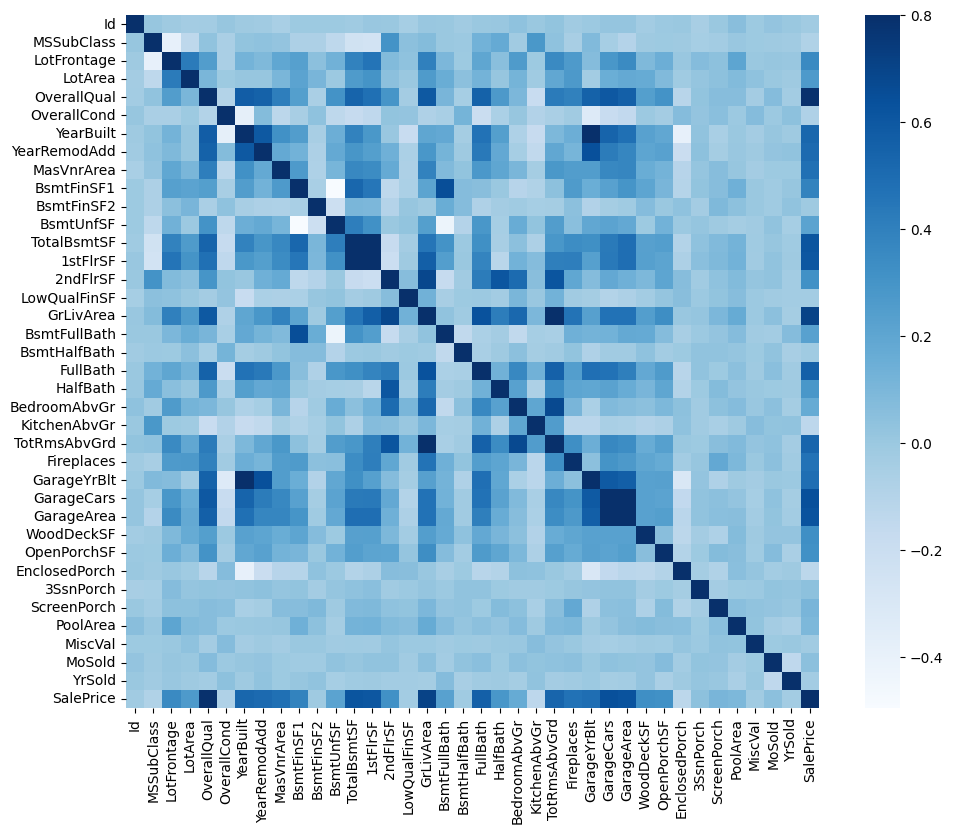

In [4]:
train_num = train.select_dtypes(include = ['int64', 'float64'])
heatmap = train_num.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(heatmap, vmax=0.8, square = True, cmap = 'Blues')

Variables that have correlations with SalePrice:

* OverallQual
* GrLivArea
* GarageCars
* GarageArea
* TotalBsmtSF
* 1stFlrSF
* FullBath
* TotRmsAbvGrd
* YearBuilt
* YearRemodAdd
* MasVnrArea
* FirePlace
* GarageYrBlt
* YearRemodAdd
* MasVnrArea
* FirePlace
* GarageYrBlt



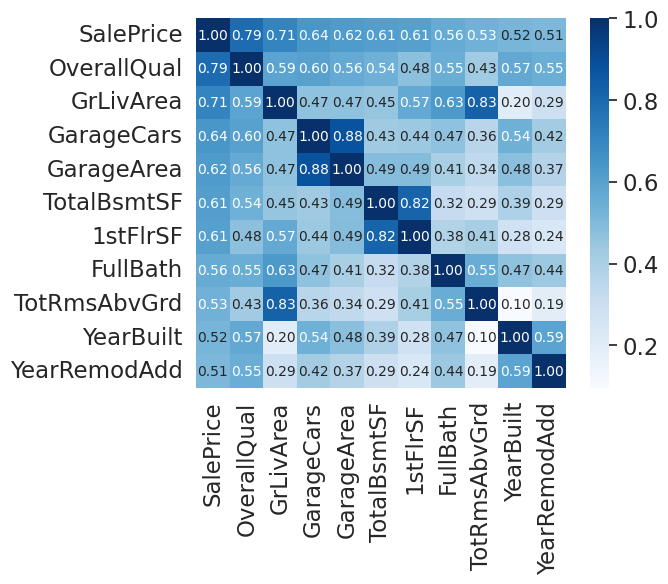

In [5]:
v = 11
cols = heatmap.nlargest(v, 'SalePrice')['SalePrice'].index
v2 = np.corrcoef(train[cols].values.T)
sns.set(font_scale = 1.5)
heatm = sns.heatmap(v2, cbar = True, annot= True, square = True, 
                   fmt = '.2f', annot_kws = {'size':10}, yticklabels = cols.
                   values, xticklabels = cols.values, cmap = 'Blues')
plt.show()

### Missing Values

Print the percentage of missing values for each column but only print columns with more than 40% of the values missing


In [6]:

missing_val = train.isnull().sum() * 100 / len(train)
missing_val = missing_val[missing_val > 40].sort_values(ascending=False)
print(missing_val)


PoolQC         99.520548
MiscFeature    96.301370
Alley          93.767123
Fence          80.753425
MasVnrType     59.726027
FireplaceQu    47.260274
dtype: float64


PoolQC, MiscFeature, Alley, Fence, MasVnrType, FireplaceQu need to be dropped from the data because they have too many missing values

In [7]:
columns_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu']

Let's do the same with the Test dataframe

In [8]:
test = pd.read_csv('/kaggle/input/house-prices-train-csv/train.csv')

In [9]:
train.drop(columns=columns_drop, inplace=True)
test.drop(columns=columns_drop, inplace=True)


### Model Building

In [10]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [11]:
X_train = train.drop(columns=['Id', 'SalePrice'])
y_train = train['SalePrice']

Let's measure the dependency between the variables(Mutual Information Score). 
* Higher MI = stronger relationship between the feature and target variable 

In [12]:
def calculate_mi(X, y):
    X_copy = X.copy()
    for colname in X_copy.select_dtypes(["object", "category"]):
        X_copy[colname], _ = X_copy[colname].factorize()
    X_copy = X_copy.fillna(0)
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X_copy.dtypes]
    mi = mutual_info_regression(X_copy, y, discrete_features=discrete_features, random_state=0)
    mi = pd.Series(mi, name="MI Scores", index=X_copy.columns)
    mi = mi.sort_values(ascending=False)
    return mi


In [13]:
mi = calculate_mi(X_train, y_train)
mi_below_one = mi[mi < 0.001].index.tolist()
print(mi_below_one)

['3SsnPorch', 'Street', 'Utilities', 'PoolArea', 'MiscVal', 'MoSold']


These columns need to be dropped as well because their MI score is below 1, meaning these columns lack correlation with our target variable therefore we don't need to consider them in our analysis: 
* 3SsnPorch
* Street
* Utilities
* Pool Area
* MiscVal
* MoSold




In [14]:
columns_drop2 = ['3SsnPorch', 'Street', 'Utilities', 'PoolArea', 'MiscVal', 'MoSold']
X_train.drop(columns=columns_drop2, inplace=True)
test.drop(columns=columns_drop2, inplace=True)

### Gradient Boosting Machines and Preprocessing

GBMs build models sequentially, where each subsequent model attempts to correct the errors made by the previous models

Below is the ML pipeline for preprocessing both numeric and categorical features and then fitting a regression model using Gradient Boosting. 

First, let's identify the Numeric and Categorical Features

In [15]:
num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_feat = X_train.select_dtypes(include=['object']).columns

Let's define the Numeric and Categorical transformers

* the numeric transformer uses 'SimpleImputer' to fill in missing values in the numeric features with the median value of each column
* the categorical transformer uses 'Pipeline'to process categorical features: 
    * SimpleImputer(strategy='constant', fill_value='missing'): Fills missing values in categorical features with the constant value 'missing'.
    * OneHotEncoder(handle_unknown='ignore'): Converts categorical features into one-hot encoded vectors, ignoring any unknown categories during transformation.
   

In [16]:
num_trans = SimpleImputer(strategy='median')
cat_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


#### Combining the Preprocessing Steps:

* preprocessor: Uses ColumnTransformer to apply the numeric and categorical transformations to the appropriate columns:

    * ('num', num_trans, num_feat): Applies the numeric transformer to the numeric features.

    * ('cat', cat_trans, cat_feat): Applies the categorical transformer to the categorical features.


In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_trans, num_feat),
        ('cat', cat_trans, cat_feat)
    ])

In [18]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', GradientBoostingRegressor())])

Perform hyperparameter tuning to conduct an exhaustive search over the below specified parameter grid. 

In [19]:
param_grid = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'regressor__max_depth': [3, 4, 5, 6, 7, 8],
    'regressor__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'regressor__min_samples_split': [2, 5, 10, 15],
    'regressor__min_samples_leaf': [1, 2, 4, 6],
    'regressor__max_features': [1.0, 'sqrt', 'log2', None],
    'regressor__loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
    'regressor__alpha': [0.1, 0.2, 0.5, 0.9],
    'regressor__warm_start': [True, False],
    'regressor__n_iter_no_change': [None, 5, 10, 15]
}



In [20]:
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=200, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(strategy='median'),
                                                                               Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea'...
                                        'regressor__max_features': [1.0, 'sqrt',
                                                                    'log2',
                                                                    None],
                                        'regressor__min_samples_leaf': [1, 2, 4,
                                                                        6],
                                        'regressor__min_samples_split': [2, 5,
                                                                         10,
                                                                         15],
                                        'regressor__n_estimators': [100, 200,
                                                                    300, 400,
                                                                    500],
                                        'regressor__n_iter_no_change': [None, 5,
                                                                        10,
                                                                        15],
                                        'regressor__subsample': [0.6, 0.7, 0.8,
                                                                 0.9, 1.0],
                                        'regressor__warm_start': [True, False]},
                   random_state=42, scoring='neg_mean_squared_error')

In [21]:
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", -random_search.best_score_)

Best parameters found:  {'regressor__warm_start': True, 'regressor__subsample': 0.6, 'regressor__n_iter_no_change': 15, 'regressor__n_estimators': 100, 'regressor__min_samples_split': 15, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 1.0, 'regressor__max_depth': 5, 'regressor__loss': 'squared_error', 'regressor__learning_rate': 0.05, 'regressor__alpha': 0.2}
Best cross-validation score:  720311623.8737043


Let's print the best parameters found in a cleaner, easier to read, format. 

In [22]:
params = random_search.best_params_
cleaned_params = {key.replace('regressor__', ''): value for key, value in params.items()}
print(cleaned_params)

{'warm_start': True, 'subsample': 0.6, 'n_iter_no_change': 15, 'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': 5, 'loss': 'squared_error', 'learning_rate': 0.05, 'alpha': 0.2}


Let's get the House predictions and create a dataframe for the output: 

In [23]:
ids = test['Id']
Xx = test.drop(columns=['Id'])
y_pred = random_search.predict(Xx)
output = pd.DataFrame({'Id': ids, 'SalePrice': y_pred})
output

,Id,SalePrice
0,1,203239.584397
1,2,168985.263978
2,3,210121.830028
3,4,163076.434589
4,5,275057.936359
...,...,...
1455,1456,170576.663667
1456,1457,209409.727761
1457,1458,254478.565927
1458,1459,133348.392158
